### Task 1.1

Shit....! Here we go again!

We are looking at Private individuals vs Business actors again

In [1]:
import ast

import numpy as np
import pandas as pd
from image_analysis.data import get_images_dataframe

from sdm.config import get_db_connection

In [2]:
conn = get_db_connection(db_type="sqlite", db_path="D:/UU/Sem3/SDM/social_data_mining/data/twitter.db")
df = get_images_dataframe(db=conn)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38980 entries, 0 to 38979
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   account_id    38980 non-null  object
 1   image_id      38980 non-null  object
 2   account_type  38980 non-null  object
 3   lang          38729 non-null  object
 4   stance        38441 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB
None


,account_id,image_id,account_type,lang,stance
0,8508262,nan,Private individuals,fr,For
1,8508262,nan,Private individuals,fr,For
2,8508262,nan,Private individuals,fr,For
3,8508262,nan,Private individuals,fr,For
4,8508262,nan,Private individuals,fr,For


In [3]:
valid_img_df = df.copy()
valid_img_df["image_id"] = valid_img_df["image_id"].apply(lambda x: np.nan if x == "nan" else x)
valid_img_df = valid_img_df.dropna(subset=["image_id"])
# valid_img_df["image_id"] = valid_img_df["image_id"].apply(lambda x: x["media_keys"])
valid_img_df['image_id'] = valid_img_df['image_id'].apply(
    lambda x: ast.literal_eval(x)['media_keys']
)
valid_img_df = valid_img_df.reset_index(drop=True)
print(valid_img_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16387 entries, 0 to 16386
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   account_id    16387 non-null  object
 1   image_id      16387 non-null  object
 2   account_type  16387 non-null  object
 3   lang          16260 non-null  object
 4   stance        16188 non-null  object
dtypes: object(5)
memory usage: 640.2+ KB
None


In [4]:
valid_img_df.head(20)

,account_id,image_id,account_type,lang,stance
0,8508262,[3_669872845984546817],Private individuals,fr,For
1,8508262,[3_671208626439213056],Private individuals,fr,For
2,8508262,[3_671223094661545984],Private individuals,fr,For
3,8508262,[3_671231051176517632],Private individuals,fr,For
4,8508262,[3_671231164783398913],Private individuals,fr,For
5,8508262,[3_671231221045829632],Private individuals,fr,For
6,8508262,[3_671245770083831808],Private individuals,fr,For
7,8508262,[3_671248838741520384],Private individuals,fr,For
8,8508262,"[3_671250676698214400, 3_671250676580794368, 3...",Private individuals,fr,For
9,8508262,[3_671253906081607680],Private individuals,fr,For


### Task 1.2: Bag of Visual Words

In [5]:
import os

import torch
from PIL import Image
from transformers import OwlViTForObjectDetection, OwlViTProcessor

In [6]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [7]:
image_dir = f"D:/UU/Sem3/SDM/social_data_mining/data/media/"

In [8]:
def process_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        
        queries = ["photo of a person", "photo of a flag", "photo of a building", "photo of a tree", "photo of the sky", "photo of people", "photo of computer", "photo of a screen", "photo of agroup"]
        
        inputs = processor(images=image, text=queries, return_tensors="pt")
        
        outputs = model(**inputs)
        
        target_sizes = torch.tensor([image.size[::-1]])
        results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.5)
        
        detected_labels = [
            queries[label] for score, label in zip(results[0]["scores"], results[0]["labels"]) if score > 0.3
        ]
        return detected_labels
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return []

In [9]:
def find_image_file(image_id):
    for ext in ['.jpg', '.png', '.jpeg']:
        image_path = os.path.join(image_dir, f"{image_id}{ext}")
        if os.path.isfile(image_path):
            return image_path
    return image_id

In [10]:
def create_bag_of_words(row):
    all_detected_labels = []
    for image_id in row["image_id"]:
        image_path = find_image_file(image_id)
        detected_labels = process_image(image_path)
        all_detected_labels.extend(detected_labels)
        
    return list(set(all_detected_labels))

In [29]:
valid_img_df["bag_of_words"] = valid_img_df.apply(create_bag_of_words, axis=1)
print(valid_img_df.info())

KeyboardInterrupt: 

In [25]:
valid_img_df.head(20)

,account_id,image_id,account_type,lang,stance,bag_of_words
0,8508262,[3_669872845984546817],Private individuals,fr,For,[]
1,8508262,[3_671208626439213056],Private individuals,fr,For,[]
2,8508262,[3_671223094661545984],Private individuals,fr,For,[]
3,8508262,[3_671231051176517632],Private individuals,fr,For,[]
4,8508262,[3_671231164783398913],Private individuals,fr,For,[]
5,8508262,[3_671231221045829632],Private individuals,fr,For,[]
6,8508262,[3_671245770083831808],Private individuals,fr,For,[]
7,8508262,[3_671248838741520384],Private individuals,fr,For,[]
8,8508262,"[3_671250676698214400, 3_671250676580794368, 3...",Private individuals,fr,For,[]
9,8508262,[3_671253906081607680],Private individuals,fr,For,[]


In [26]:
non_empty_bow_df = valid_img_df[valid_img_df["bag_of_words"].apply(lambda x: len(x) > 0)]
non_empty_bow_df = non_empty_bow_df.reset_index(drop=True)
print(non_empty_bow_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   account_id    1 non-null      object
 1   image_id      1 non-null      object
 2   account_type  1 non-null      object
 3   lang          1 non-null      object
 4   stance        1 non-null      object
 5   bag_of_words  1 non-null      object
dtypes: object(6)
memory usage: 180.0+ bytes
None


In [27]:
non_empty_bow_df.head(20)

,account_id,image_id,account_type,lang,stance,bag_of_words
0,76326683,[3_674208260166152193],Private individuals,fr,For,[sky]


In [21]:
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
non_empty_bow_df["bag_of_words_str"] = non_empty_bow_df["bag_of_words"].apply(lambda x: " ".join(x))

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(non_empty_bow_df["bag_of_words_str"])

feature_matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print("Feature matrix: ")
print(feature_matrix)

Feature matrix: 
      building  flag  of  person  photo  tree
0            0     0   1       1      1     0
1            0     1   1       0      1     0
2            0     1   1       0      1     0
3            0     1   1       0      1     0
4            0     1   1       0      1     0
...        ...   ...  ..     ...    ...   ...
1204         0     0   1       1      1     0
1205         0     0   1       1      1     0
1206         0     0   1       1      1     0
1207         0     0   1       1      1     0
1208         0     0   1       1      1     0

[1209 rows x 6 columns]


### Task 1.3: CNN

In [11]:
import os

import numpy as np
import pandas as pd
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [12]:
image_dir = f"D:/UU/Sem3/SDM/social_data_mining/data/media/"

In [13]:
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

d:\UU\Sem3\SDM\social_data_mining\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UU\Sem3\SDM\social_data_mining\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\anand/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.8MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
def extract_embeddings(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0)
        with torch.no_grad():
            embedding = model(image).squeeze().numpy()
        return embedding
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [16]:
def get_embeddings(image_ids):
    embeddings = []
    for image_id in image_ids:
        for ext in ['.jpg', '.png', '.jpeg']:
            image_path = os.path.join(image_dir, f"{image_id}{ext}")
            if os.path.isfile(image_path):
                embedding = extract_embeddings(image_path)
                if embedding is not None:
                    embeddings.append(embedding)
                break
            
    return np.mean(embeddings, axis=0) if embeddings else None

In [17]:
valid_img_df["embeddings"] = valid_img_df["image_id"].apply(lambda x: get_embeddings(x))
print(valid_img_df.info())

Error processing image D:/UU/Sem3/SDM/social_data_mining/data/media/3_674024451613192194.png: cannot identify image file 'D:\\UU\\Sem3\\SDM\\social_data_mining\\data\\media\\3_674024451613192194.png'
Error processing image D:/UU/Sem3/SDM/social_data_mining/data/media/3_675612857329950720.jpg: cannot identify image file 'D:\\UU\\Sem3\\SDM\\social_data_mining\\data\\media\\3_675612857329950720.jpg'
Error processing image D:/UU/Sem3/SDM/social_data_mining/data/media/3_674622303855108098.jpg: image file is truncated (2 bytes not processed)
Error processing image D:/UU/Sem3/SDM/social_data_mining/data/media/3_671287718702379008.jpg: cannot identify image file 'D:\\UU\\Sem3\\SDM\\social_data_mining\\data\\media\\3_671287718702379008.jpg'
Error processing image D:/UU/Sem3/SDM/social_data_mining/data/media/3_671707827455569922.jpg: cannot identify image file 'D:\\UU\\Sem3\\SDM\\social_data_mining\\data\\media\\3_671707827455569922.jpg'
Error processing image D:/UU/Sem3/SDM/social_data_mining/d

In [18]:
valid_img_df.head(20)

,account_id,image_id,account_type,lang,stance,embeddings
0,8508262,[3_669872845984546817],Private individuals,fr,For,"[0.3088449, 0.8212693, 0.20857613, 0.036441736..."
1,8508262,[3_671208626439213056],Private individuals,fr,For,"[0.9107989, 1.2203574, 1.1272554, 0.21009599, ..."
2,8508262,[3_671223094661545984],Private individuals,fr,For,"[0.08641282, 0.5696919, 0.62884784, 0.20423035..."
3,8508262,[3_671231051176517632],Private individuals,fr,For,"[0.24067032, 1.7198516, 0.45336658, 0.7189984,..."
4,8508262,[3_671231164783398913],Private individuals,fr,For,"[0.19690387, 0.9268203, 0.029400224, 0.3813832..."
5,8508262,[3_671231221045829632],Private individuals,fr,For,"[0.39009705, 1.1704558, 0.49554256, 0.35991067..."
6,8508262,[3_671245770083831808],Private individuals,fr,For,"[0.35368612, 1.8685617, 1.0610269, 0.09560947,..."
7,8508262,[3_671248838741520384],Private individuals,fr,For,"[0.11298336, 0.43587306, 0.21804191, 0.0262205..."
8,8508262,"[3_671250676698214400, 3_671250676580794368, 3...",Private individuals,fr,For,"[0.21406078, 1.1083872, 0.8372234, 0.2948038, ..."
9,8508262,[3_671253906081607680],Private individuals,fr,For,"[0.025264395, 0.6966786, 0.06352229, 0.0149451..."


In [23]:
def validate_embeddings(row):
    embedding = row['embeddings']
    if embedding is None:
        return None
    embedding = np.array(embedding)
    if len(embedding.shape) == 1:  # Ensure it's a 1D array
        return embedding
    else:
        print(f"Inconsistent embedding shape for account_id {row['account_id']}: {embedding.shape}")
        return None

In [25]:
valid_img_df["valid_embeddings"] = valid_img_df.apply(validate_embeddings, axis=1)
valid_img_df = valid_img_df[valid_img_df["valid_embeddings"].notnull()]
print(valid_img_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15535 entries, 0 to 16385
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   account_id        15535 non-null  object
 1   image_id          15535 non-null  object
 2   account_type      15535 non-null  object
 3   lang              15408 non-null  object
 4   stance            15338 non-null  object
 5   embeddings        15535 non-null  object
 6   valid_embeddings  15535 non-null  object
dtypes: object(7)
memory usage: 970.9+ KB
None


In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [29]:
embeddings = np.stack(valid_img_df["embeddings"].to_numpy())

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

In [30]:
print(embeddings_scaled)

[[ 0.43767965 -0.2011314  -0.6846298  ... -0.2176426  -0.9375848
   0.6382711 ]
 [ 3.2814167   0.38706174  1.265545   ...  0.1026983   0.6941332
   2.1818817 ]
 [-0.6131288  -0.5719169   0.20752408 ... -0.8601249  -0.8232176
  -1.1204834 ]
 ...
 [ 0.1993572   0.47791576  1.6719786  ...  0.03566873  0.46082062
  -0.37195724]
 [ 0.16901058 -0.33961734  0.60246354 ...  0.4409915   0.60521066
   0.54557306]
 [-0.49987134 -0.51901734 -0.38946024 ... -0.9727869   0.4911325
  -0.7408214 ]]


In [45]:
n_clusters = 8000
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
valid_img_df["cluster"] = kmeans.fit_predict(embeddings_scaled)

print("Clustered data:")
valid_img_df.head(20)

Clustered data:


C:\Users\anand\AppData\Local\Temp\ipykernel_26376\2731466576.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_img_df["cluster"] = kmeans.fit_predict(embeddings_scaled)


,account_id,image_id,account_type,lang,stance,embeddings,valid_embeddings,cluster
0,8508262,[3_669872845984546817],Private individuals,fr,For,"[0.3088449, 0.8212693, 0.20857613, 0.036441736...","[0.3088449, 0.8212693, 0.20857613, 0.036441736...",91
1,8508262,[3_671208626439213056],Private individuals,fr,For,"[0.9107989, 1.2203574, 1.1272554, 0.21009599, ...","[0.9107989, 1.2203574, 1.1272554, 0.21009599, ...",4264
2,8508262,[3_671223094661545984],Private individuals,fr,For,"[0.08641282, 0.5696919, 0.62884784, 0.20423035...","[0.08641282, 0.5696919, 0.62884784, 0.20423035...",3127
3,8508262,[3_671231051176517632],Private individuals,fr,For,"[0.24067032, 1.7198516, 0.45336658, 0.7189984,...","[0.24067032, 1.7198516, 0.45336658, 0.7189984,...",153
4,8508262,[3_671231164783398913],Private individuals,fr,For,"[0.19690387, 0.9268203, 0.029400224, 0.3813832...","[0.19690387, 0.9268203, 0.029400224, 0.3813832...",701
5,8508262,[3_671231221045829632],Private individuals,fr,For,"[0.39009705, 1.1704558, 0.49554256, 0.35991067...","[0.39009705, 1.1704558, 0.49554256, 0.35991067...",4889
6,8508262,[3_671245770083831808],Private individuals,fr,For,"[0.35368612, 1.8685617, 1.0610269, 0.09560947,...","[0.35368612, 1.8685617, 1.0610269, 0.09560947,...",5252
7,8508262,[3_671248838741520384],Private individuals,fr,For,"[0.11298336, 0.43587306, 0.21804191, 0.0262205...","[0.11298336, 0.43587306, 0.21804191, 0.0262205...",983
8,8508262,"[3_671250676698214400, 3_671250676580794368, 3...",Private individuals,fr,For,"[0.21406078, 1.1083872, 0.8372234, 0.2948038, ...","[0.21406078, 1.1083872, 0.8372234, 0.2948038, ...",18
9,8508262,[3_671253906081607680],Private individuals,fr,For,"[0.025264395, 0.6966786, 0.06352229, 0.0149451...","[0.025264395, 0.6966786, 0.06352229, 0.0149451...",79


In [32]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

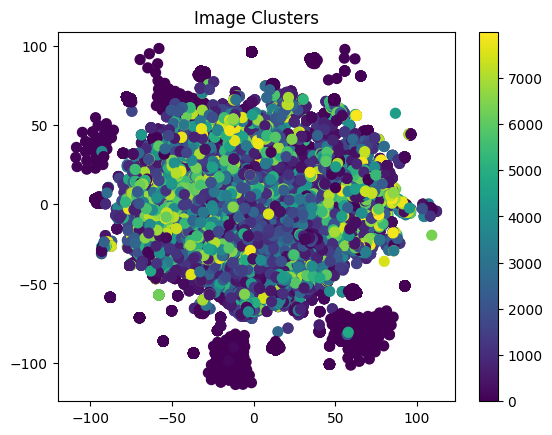

In [46]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_scaled)

# Plot clusters
plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=valid_img_df['cluster'], cmap='viridis', s=50
)
plt.colorbar()
plt.title("Image Clusters")
plt.show()

d:\UU\Sem3\SDM\social_data_mining\.venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (9284) found smaller than n_clusters (10000). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


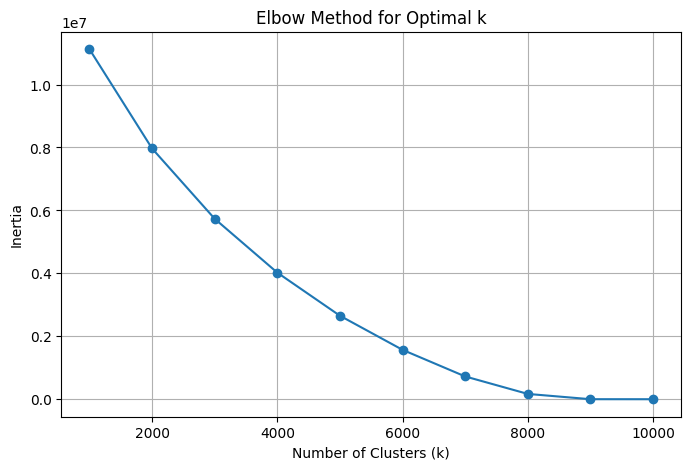

In [44]:
k_values = range(1000, 10001, 1000)

# Store the inertia for each k
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

In [47]:
print(valid_img_df['cluster'].value_counts())

cluster
22      526
4       511
10      326
26      221
16      195
       ... 
5403      1
1728      1
150       1
3155      1
3375      1
Name: count, Length: 8000, dtype: int64


In [59]:
valid_img_df[valid_img_df["cluster"] == 5281][['account_id', 'image_id']].head(20)

,account_id,image_id
383,256572677,"[3_674221152567500800, 3_674221152491995137, 3..."


In [54]:
valid_img_df[valid_img_df["account_id"] == "3911870127"].head()

,account_id,image_id,account_type,lang,stance,embeddings,valid_embeddings,cluster
5797,3911870127,[3_668732072111046656],Private individuals,en,Unclear,"[0.012178711, 0.0371624, 0.10780686, 0.2052651...","[0.012178711, 0.0371624, 0.10780686, 0.2052651...",16
5798,3911870127,[3_668732072111046656],Private individuals,en,Unclear,"[0.012178711, 0.0371624, 0.10780686, 0.2052651...","[0.012178711, 0.0371624, 0.10780686, 0.2052651...",16
5799,3911870127,[3_668732072111046656],Private individuals,en,Unclear,"[0.012178711, 0.0371624, 0.10780686, 0.2052651...","[0.012178711, 0.0371624, 0.10780686, 0.2052651...",16
5800,3911870127,[3_668732072111046656],Private individuals,en,Unclear,"[0.012178711, 0.0371624, 0.10780686, 0.2052651...","[0.012178711, 0.0371624, 0.10780686, 0.2052651...",16
5801,3911870127,[3_668732072111046656],Private individuals,en,Unclear,"[0.012178711, 0.0371624, 0.10780686, 0.2052651...","[0.012178711, 0.0371624, 0.10780686, 0.2052651...",16


In [55]:
valid_img_df[valid_img_df["account_type"] == "Business actors"].head()

,account_id,image_id,account_type,lang,stance,embeddings,valid_embeddings,cluster
379,256572677,[3_671316386803785728],Business actors,de,Unclear,"[0.008600438, 0.5608135, 0.14381006, 1.1273912...","[0.008600438, 0.5608135, 0.14381006, 1.1273912...",2100
380,256572677,[3_671593005296431104],Business actors,de,Unclear,"[0.09075959, 0.2847025, 0.3157577, 1.0328346, ...","[0.09075959, 0.2847025, 0.3157577, 1.0328346, ...",5196
381,256572677,[3_671614807703953408],Business actors,de,Unclear,"[0.15386672, 0.5850439, 0.10910018, 0.14655977...","[0.15386672, 0.5850439, 0.10910018, 0.14655977...",4655
382,256572677,[3_673832675627565056],Business actors,de,Unclear,"[0.5221925, 0.54281276, 0.58903676, 0.57326794...","[0.5221925, 0.54281276, 0.58903676, 0.57326794...",3615
383,256572677,"[3_674221152567500800, 3_674221152491995137, 3...",Business actors,de,Unclear,"[0.3943156, 0.80126756, 1.3790299, 0.84069914,...","[0.3943156, 0.80126756, 1.3790299, 0.84069914,...",5281


### Task 1.4: VLLM